**Play Notebook**

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import albumentations as A
import os
from albumentations.pytorch import ToTensorV2
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, Dataset
from types import SimpleNamespace
import torch.nn as nn
from timm import create_model, list_models
import torch.nn.functional as F

2024-07-03 19:14:30.035011: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 19:14:30.962407: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


RuntimeError: Detected that PyTorch and torchvision were compiled with different CUDA major versions. PyTorch has CUDA Version=11.8 and torchvision has CUDA Version=12.1. Please reinstall the torchvision that matches your PyTorch install.

In [3]:
root='/kaggle/input/flickr8k/Images'
annot_txt='/kaggle/input/flickr8k/captions.txt'

In [4]:
image_files=os.listdir(root)
file1=image_files[0]
file1_path=os.path.join(root, file1)
img1=plt.imread(file1_path)

In [5]:
img1.shape

(333, 500, 3)

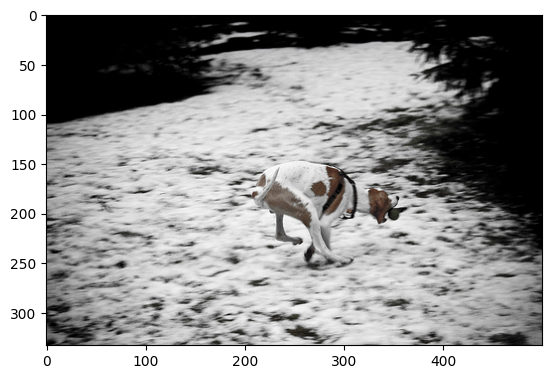

In [6]:
plt.imshow(img1)

In [7]:
caption_df=pd.read_csv(annot_txt)

In [8]:
caption_df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [9]:
hashmap={caption_df['image'][i]: caption_df['caption'][i] for i in range(len(caption_df))}

In [10]:
hashmap[file1]

'The brown and white dog is playing in the snow .'

****Dataset****

In [11]:
train_transforms=A.Compose([A.HorizontalFlip(), 
           A.RandomBrightnessContrast(),
           A.Resize(224,224),
           A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], always_apply=True),
           ToTensorV2()])

validation_transforms=A.Compose([A.Resize(224,224),
                                 A.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5], always_apply=True),
                                 ToTensorV2()])

In [12]:
tokeniser=GPT2TokenizerFast.from_pretrained('gpt2')
tokeniser.pad_token=tokeniser.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [13]:
tokeniser.pad_token

'<|endoftext|>'

In [14]:
tokeniser.encode_plus('hello! I am Susmit')

{'input_ids': [31373, 0, 314, 716, 8932, 2781], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [15]:
class dataset:
    def __init__ (self, annot_path, img_path, transforms):
        self.df=pd.read_csv(annot_path)
        self.df['image']=self.df['image'].apply(lambda x: os.path.join(img_path, x))
        self.transforms=transforms
        self.tokeniser=GPT2TokenizerFast.from_pretrained('gpt2')
        self.tokeniser.pad_token=self.tokeniser.eos_token
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row=self.df.iloc[index,:]
        img=row['image']
        cap=row['caption']
        img=Image.open(img).convert('RGB')
        img=np.array(img)
        augs=self.transforms(image=img)
        img=augs['image']
        cap=f'{cap}<|endoftext|>'
        ids=self.tokeniser.encode_plus(cap, truncation=True)['input_ids']
        labels=ids.copy()
        labels[:-1]=ids[1:] ## To remove the eos padding from labels
        return img, ids, labels

In [16]:
img_path='flickr_8k/Images'
annot_path='flickr_8k/captions.txt'

In [17]:
def collate_fn(batch):
    img=[i[0] for i in batch]
    ids=[i[1] for i in batch]
    lab=[i[2] for i in batch]
    
    img=torch.stack(img, dim=0)
    ids=tokeniser.pad({'input_ids':ids}, padding='longest',
                     return_attention_mask=False,
                     return_tensors='pt')['input_ids']
    lab=tokeniser.pad({'input_ids':lab}, padding='longest',
                     return_attention_mask=False,
                     return_tensors='pt')['input_ids']
    return img, ids, lab

In [18]:
ds=dataset(annot_path=annot_path, img_path=img_path, transforms=train_transforms)

In [19]:
dataloader=DataLoader(dataset=ds, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [20]:
_,c,l=next(iter(dataloader))
print(c[0])

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


tensor([ 7571,  4346,  3466,   711,   319,   262,  2214,   764, 50256, 50256,
        50256, 50256, 50256, 50256])


****Attention Blocks****

In the Transformer architecture, the query, key, and value vectors are calculated by multiplying the input embedding vectors with learned weight matrices.
So the attention layer is a Linear function which takes in input embeddings and returns k, q, v each of size n_headsx

In [21]:
class CausalAttention(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embed_dim=config.embed_dim
        self.num_heads=config.num_heads
        self.head_size=self.embed_dim//self.num_heads
        self.seq_len=config.seq_len
        self.attn=nn.Linear(self.embed_dim, self.head_size*self.num_heads*3, bias=True)
        self.scale=self.head_size**-0.5
        self.register_buffer('mask', torch.tril(torch.ones(1,1,self.seq_len, self.seq_len)))
        self.proj=nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout=nn.Dropout(config.attn_dropout)
        self.resid_dropout=nn.Dropout(config.resid_dropout)
        
    def forward(self,x):
        i,j,k=x.shape
        q,k,v=self.attn(x).chunk(3, dim=-1)
        q=q.view(i, j, self.num_heads, self.head_size).permute(0,2,1,3)
        k=k.view(i, j, self.num_heads, self.head_size).permute(0,2,1,3)
        v=v.view(i, j, self.num_heads, self.head_size).permute(0,2,1,3)
        qk_t=q@k.transpose(-2,-1)*self.scale
        qk_t=qk_t.masked_fill(self.mask[:,:,:j, :j]==0, float('-inf'))
        qk_t=F.softmax(qk_t, dim=-1)
        weights=self.attn_dropout(qk_t)
        attention=weights@v
        attention=attention.permute(0,2,1,3).contiguous().view(i,j,k)
        out=self.proj(attention)
        out=self.resid_dropout(attention)
        
        return out

****Cross Attention****

In [22]:
class CrossAttention(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embed_dim=config.embed_dim
        self.num_heads=config.num_heads
        self.head_size=self.embed_dim//self.num_heads
        self.seq_len=config.seq_len
        self.attn=nn.Linear(self.embed_dim, self.head_size*self.num_heads*3, bias=True)
        self.scale=self.head_size**-0.5
        self.proj=nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        self.attn_dropout=nn.Dropout(config.attn_dropout)
        self.resid_dropout=nn.Dropout(config.resid_dropout)
        self.q=nn.Linear(self.embed_dim, self.embed_dim)
        self.k=nn.Linear(self.embed_dim, self.embed_dim)
        self.v=nn.Linear(self.embed_dim, self.embed_dim)
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
    def forward(self,q,k,v):
        i,j,k=q.shape
        q=self.q(q)
        k=self.k(k)
        v=self.v(v)
        
        q=q.view(i, j, self.num_heads, self.head_size).permute(0,2,1,3)
        k=k.view(i, j, self.num_heads, self.head_size).permute(0,2,1,3)
        v=v.view(i, j, self.num_heads, self.head_size).permute(0,2,1,3)
        qk_t=q@k.transpose(-2,-1)*self.scale
        qk_t=qk_t.masked_fill(self.mask[:,:,:j, :j]==0, float('-inf'))
        qk_t=F.softmax(qk_t, dim=-1)
        weights=self.attn_dropout(qk_t)
        attention=weights@v
        attention=attention.permute(0,2,1,3).contiguous().view(i,j,k)
        out=self.proj(attention)
        out=self.resid_dropout(attention)
        
        return out

****MLP Block****

In [23]:
class MLP(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embed_dim=config.embed_dim
        self.mlp_ratio=config.mlp_ratio
        self.mlp_dropout=config.dropout
        self.fc=nn.Linear(self.embed_dim, self.embed_dim*self.mlp_ratio)
        self.proj=nn.Linear(self.embed_dim*self.mlp_ratio, self.embed_dim)
        self.activation=nn.GELU()
        self.dropout=nn.Dropout(self.mlp_dropout)
    def forward(self, x):
        x=self.fc(x)
        x=self.activation(x)
        x=self.proj(x)
        x=self.dropout(x)
        return x

****Decoder****

In [24]:
class Decoder(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.embed_dim=config.embed_dim
        self.ln1=nn.LayerNorm(self.embed_dim)
        self.attn=CausalAttention(config)
        self.ln2=nn.LayerNorm(self.embed_dim)
        self.mlp=MLP(config)
        self.ln3=nn.LayerNorm(config)
        self.cross_attn=CrossAttention(config)
    
    def forward(self, x, enc_out):
        x=x+self.attn(self.ln1(x))
        x=x+self.cross_attn(self.ln2(x), enc_out, enc_out)
        x=x+self.mlp(self.ln3(x))
        return x

****ViT Block****

In [ ]:
class VIT(nn.Module):
    def __init__ (self, config):
        super().__init__()
        self.config=config
        vit=create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.patch_embed=vit.patch_embed
        self.num_patches=vit.patch_embed.num_patches
        self.cls_token=vit.cls_token
        self.embed_len=self.num_patches+vit.num_prefix_tokens
        self.pos_embed=vit.pos_embed
        self.pos_dropout=nn.Dropout(p=0)
        self.blocks=nn.ModuleList([vit.blocks[i] for i in range(config.depth)])
        self.transformer=nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.embed_dim), 
            wpe=nn.Embedding(config.seq_len, config.embed_dim ), 
            drop=nn.Dropout(config.emb_dropout), 
            h=nn.ModuleList([Decoder(config) for _ in range(config.depth)]), 
            ln_f=nn.LayerNorm(config.embed_dim)))
        self.lm_head=nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        self.transformer.wte.weight=self.lm_head.weight
        